In [1]:
import numpy as np
import pandas as pd
import os
import time

import warnings
warnings.filterwarnings(action='ignore')

from scipy.sparse.linalg import svds
from scipy import sparse

import sklearn
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

from recsystools import *

In [2]:
from IPython.display import display, HTML 
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow

In [3]:
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"bottleneck version: {bn.__version__}")

numpy version: 1.18.5
pandas version: 1.0.5
scipy version: 1.4.1
sklearn version: 0.23.1
bottleneck version: 1.3.2


### Download data set via this URL:
#### https://www.kaggle.com/carrie1/ecommerce-data

# `Import Data`

In [4]:
user_purch_list=pd.read_csv("ecommerce_data.csv", encoding = 'ISO-8859-1')

In [5]:
user_purch_list_list = user_purch_list.loc[user_purch_list['Quantity'] > 0]
user_purch_list = user_purch_list.loc[user_purch_list['UnitPrice'] > 0]
user_purch_list = user_purch_list.dropna(subset=['CustomerID'])
user_purch_list.CustomerID=user_purch_list.CustomerID.astype(int)

In [6]:
# 필터링을 마친 새로운 raw data와, 유저의 활동 로그, 아이템의 판매 기록을 각각 저장
raw_data, user_activity, item_popularity = filter_triplets(user_purch_list)

# 새로운 raw data로 interaction matrix 계산
pivot=pd.pivot_table(raw_data, values="InvoiceNo",index=["CustomerID"],columns=["StockCode"],aggfunc="count",fill_value=0)

# sparsity는?
sparsity = 1-( 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0]))

print("After filtering, there are %d buying events from %d users and %d items (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 404966 buying events from 4124 users and 3317 items (sparsity: 97.040%)


# `Data Preprocessing`

In [16]:
train_test_split_img = Image.open("train_test_split_example.png")

In [17]:
img = train_test_split_img.resize((int(1.618*500),int(1*500)), Image.ANTIALIAS)

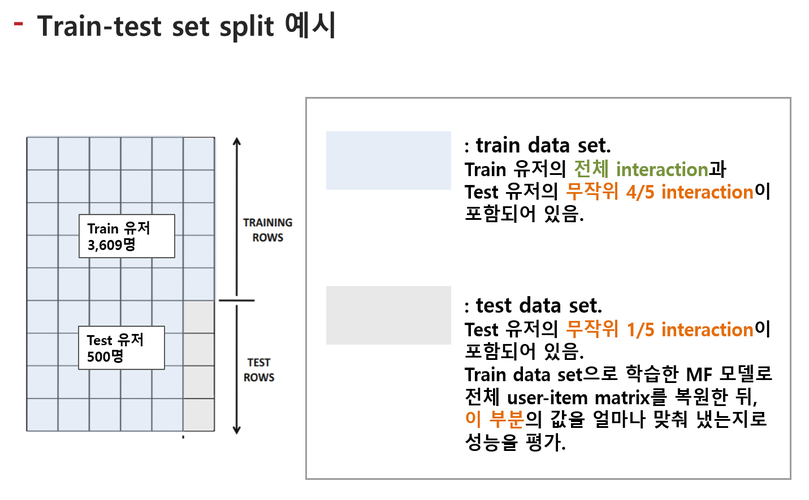

In [93]:
img

In [7]:
# 유니크한 유저 아이디를 저장
unique_uid = user_activity.index

# 균일하게 섞어주기 위해 shuffle
np.random.seed(34)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [8]:
# 유저의 수를 나누어, train/test를 split함
# 500명의 유저를 hold, 추천 모델 성능 test 용으로 사용

n_users = unique_uid.size
n_heldout_users = 500

tr_users = unique_uid[:(n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [9]:
tr_users.shape

(3624,)

In [10]:
te_users.shape

(500,)

In [11]:
tr_df=raw_data[raw_data.CustomerID.isin(tr_users)]
te_df=raw_data[raw_data.CustomerID.isin(te_users)]

In [13]:
te_tr,te_te=split_train_test_proportion(te_df)
holdout_user_list=te_te.CustomerID.unique()

0 users sampled


In [14]:
# 전체 train 데이터
train_data=pd.concat([tr_df,te_tr])

train_pivot=pd.pivot_table(train_data, values="InvoiceNo",index=["CustomerID"],columns=["StockCode"],aggfunc="count",fill_value=0)

In [15]:
matrix=train_pivot.values

#demean mean

user_ratings_mean=np.mean(matrix,axis=1)
ui_matrix=matrix-user_ratings_mean.reshape(-1,1)

# `SVD`

In [19]:
NDCG_img = Image.open("NDCG_example.png")

In [20]:
NDCG_img = NDCG_img.resize((int(1.618*500),int(1*500)), Image.ANTIALIAS)

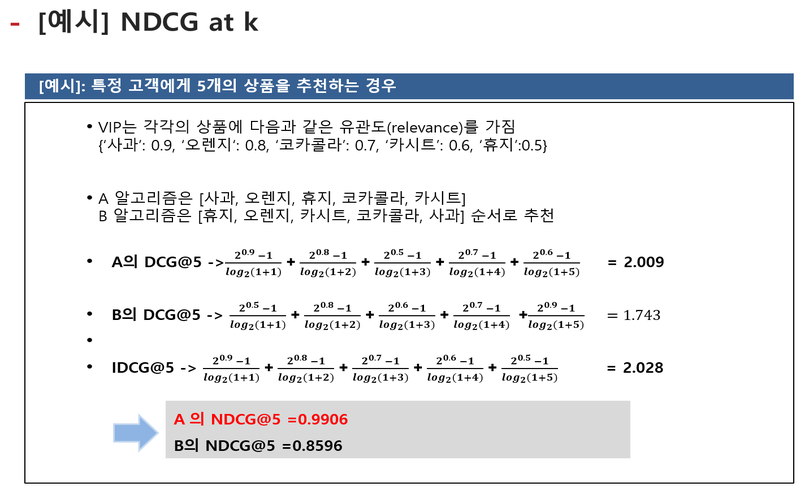

In [94]:
NDCG_img

In [23]:
ui_matrix.shape

(4124, 3213)

In [24]:
start=time.time()

U, sig , Vt =svds(ui_matrix,k=200)

print(f"training time: {time.time()-start}s")

sig=np.diag(sig)

svd_user_predicted_ratings=np.dot(np.dot(U,sig),Vt) + user_ratings_mean.reshape(-1,1)

training time: 5.70560097694397s


In [25]:
ui_matrix[0]

array([-0.05664488, -0.05664488, -0.05664488, ..., -0.05664488,
       -0.05664488, -0.05664488])

In [26]:
svd_user_predicted_ratings[0]

array([0.23289985, 0.02244812, 0.04073671, ..., 0.03452784, 0.58421431,
       0.20106048])

In [27]:
df_svd_preds=pd.DataFrame(svd_user_predicted_ratings, columns=train_pivot.columns).T
df_svd_preds.columns=train_pivot.index

In [28]:
df_svd_preds_exclude_purchase=df_svd_preds-(1e+10*(train_pivot.T))

In [29]:
pred_svd=np.array(df_svd_preds_exclude_purchase.T[df_svd_preds_exclude_purchase.columns.isin(holdout_user_list)])

In [30]:
holdout_svd=scipy.sparse.csr_matrix(pivot[pivot.T.columns.isin(holdout_user_list)].values)

In [34]:
# k=200
print(f"NDCG at 10, k = 200: " , NDCG_binary_at_k_batch(pred_svd,holdout_svd,10).mean())
print(f"Recall at 10, k = 200 :",Recall_at_k_batch(pred_svd,holdout_svd,10).mean())

NDCG at 10, k = 200:  0.113791549471326
Recall at 10, k = 200 : 0.09787380952380953


# `NMF`

In [35]:
start=time.time()

model = NMF(n_components=50, init='random', random_state=0)
W = model.fit_transform(matrix)
H = model.components_

print(f"training time: {time.time()-start}s")

training time: 25.53067946434021s


In [36]:
reconstructed = pd.DataFrame(np.round(np.dot(W,H),2), columns=train_pivot.columns,index=train_pivot.index)

In [37]:
df_nmf_preds_exclude_purchase=reconstructed.T-(1e+10*train_pivot.T)

In [38]:
pred_nmf=np.array(df_nmf_preds_exclude_purchase.T[df_nmf_preds_exclude_purchase.columns.isin(holdout_user_list)])

In [39]:
holdout_nmf=scipy.sparse.csr_matrix(pivot[pivot.T.columns.isin(holdout_user_list)].values)

In [40]:
# n=100
print("NDCG at 10, n = 50 : ",NDCG_binary_at_k_batch(pred_nmf,holdout_nmf,10).mean())

# k=50
print("Recall at 10, n = 50 : ", Recall_at_k_batch(pred_nmf,holdout_nmf,10).mean())

NDCG at 10, n = 50 :  0.08066898455503188
Recall at 10, n = 50 :  0.06880476190476191


# Prediction

In [84]:
def get_top_items(user_idx,k=10):
    user_id=unique_uid[tr_users.shape[0]+user_idx]

    pred_user=pred_svd[user_idx]
    top_10=pred_user.argsort()[:k]

    rec=user_purch_list[user_purch_list.StockCode.isin(pivot.iloc[:,top_10].columns)].drop_duplicates("StockCode")

    bought=user_purch_list[user_purch_list.CustomerID==user_id].drop_duplicates("StockCode")
    
    return rec, bought

In [85]:
rec,bought=get_top_items(10,10)

In [86]:
rec

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
103,536378,21931,JUMBO STORAGE BAG SUKI,10,12/1/2010 9:37,1.95,14688,United Kingdom
191,536388,22922,FRIDGE MAGNETS US DINER ASSORTED,12,12/1/2010 9:59,0.85,16250,United Kingdom
270,536395,21314,SMALL GLASS HEART TRINKET POT,8,12/1/2010 10:47,2.10,13767,United Kingdom
370,536401,20726,LUNCH BAG WOODLAND,1,12/1/2010 11:21,1.65,15862,United Kingdom
372,536401,22467,GUMBALL COAT RACK,5,12/1/2010 11:21,2.55,15862,United Kingdom
3520,536635,21868,POTTING SHED TEA MUG,12,12/2/2010 11:22,1.25,15955,United Kingdom
17260,537692,22937,BAKING MOULD CHOCOLATE CUPCAKES,2,12/8/2010 10:40,2.55,14796,United Kingdom
133227,547730,23159,SET OF 5 PANCAKE DAY MAGNETS,1,3/25/2011 11:01,2.08,14796,United Kingdom
133229,547730,23156,SET OF 5 MINI GROCERY MAGNETS,1,3/25/2011 11:01,2.08,14796,United Kingdom
179020,552257,23209,LUNCH BAG DOILEY PATTERN,10,5/8/2011 11:08,1.65,16923,United Kingdom


In [87]:
bought

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
43370,540033,47591D,PINK FAIRY CAKE CHILDRENS APRON,25,1/4/2011 14:12,1.65,13680,United Kingdom
43371,540033,22365,DOORMAT RESPECTABLE HOUSE,1,1/4/2011 14:12,7.95,13680,United Kingdom
43372,540033,48138,DOORMAT UNION FLAG,1,1/4/2011 14:12,7.95,13680,United Kingdom
43373,540033,22366,DOORMAT AIRMAIL,1,1/4/2011 14:12,7.95,13680,United Kingdom
43374,540033,22692,DOORMAT WELCOME TO OUR HOME,1,1/4/2011 14:12,7.95,13680,United Kingdom
...,...,...,...,...,...,...,...,...
538316,581404,23543,WALL ART KEEP CALM,2,12/8/2011 13:47,4.15,13680,United Kingdom
538317,581404,22632,HAND WARMER RED RETROSPOT,13,12/8/2011 13:47,2.10,13680,United Kingdom
538318,581404,22633,HAND WARMER UNION JACK,6,12/8/2011 13:47,2.10,13680,United Kingdom
538319,581404,22866,HAND WARMER SCOTTY DOG DESIGN,9,12/8/2011 13:47,2.10,13680,United Kingdom
